In [1]:
# JM: Feb 19 2020

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft

from IPython.display import HTML
import matplotlib.animation as animation

In [2]:
# read in the Singapore winds data and plot it out

# open the text file and dump it out, then manipulate it into a usable form
f = open("singapore.txt", "r")
lines = []
for line in f:
    lines.append(line)
f.close()
# put the data in a 2d array of (time, depth)
# 14 depth entries (rows), 12 months (columns)
depths = 14
years = int(len(lines) / depths * 12)
u_singapore = np.zeros((depths, years))
for line in range(len(lines)):
    i_depth = line % depths
    year = int(line / 14)
    i_start = 12 * year
    i_end   = 12 * (year + 1)
    u_singapore[i_depth, i_start:i_end] = np.asarray([float(i) for i in lines[line].split()[1::]])
    
t_vec = 1987 + np.arange(0, 360) / 12
pressure = np.asarray([10, 12, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90])
z = 8.0 * np.log(1013.0 / pressure)
u_singapore /= 10.0 # convert to m/s

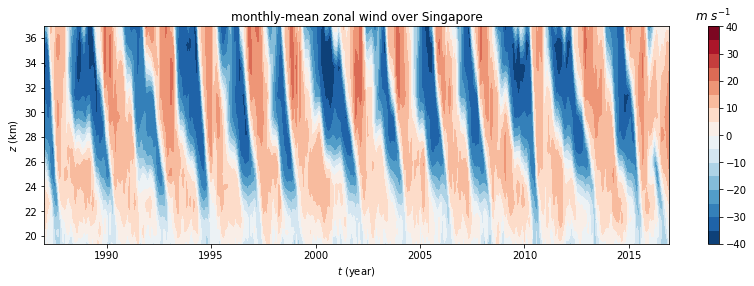

In [3]:
fig = plt.figure(figsize = (14, 4))
ax = plt.axes()
cs = ax.contourf(t_vec, z, u_singapore, levels = np.arange(-40, 41, 5), cmap = "RdBu_r")

ax.set_xlabel(r"$t$ (year)")
ax.set_ylabel(r"$z$ (km)")
ax.set_title(r"monthly-mean zonal wind over Singapore")
cax = plt.colorbar(cs)
cax.ax.set_title(r"$m\ s^{-1}$")

fig.savefig("../figures/singapore.png", bbox_inches = 'tight', dpi = 150)

In [6]:
# QBO model of Holton & Lindzen (e.g. Oliver Buhler's book)
# an integral equation, implementation based on Jacques Vanneste's MATLAB implementation

L = 10   # height of domain (non-dim)
N = 100  # number of grid points in z
nu = 0.1 # viscosity

amp  = 0.12  # amplitude of wave
c    = 0.85  # tuning parameters (wave speed)
tmax = 30    # years

# set up the time and space grid
z = np.arange(1, N + 1) * L / (N + 1)
dz = L / (N + 1)
k = np.arange(1, N + 1) # vertical wave numbers

dt = 0.1 # time step
nt = int(tmax * 500 / 30 / dt)
t = np.arange(1, nt + 1) * dt * tmax / 500;

decay = np.exp(-nu * dt * k ** 2) # decay factor for viscous dissipation step

u = np.zeros((N, nt))
u[:, 0] = 0.1 * np.sin(2 * np.pi * z / L) # initial condition

for j in range(nt - 1):
    uhat = fft.dst(u[:, j], type = 2)
    uhat *= decay # viscous dissipation in spectral space
    v = fft.idst(uhat, type = 2) / (2 * N) # normalisation
    int1 = 0.1 * np.cumsum((v - c) ** -2) * dz
    int2 = 0.1 * np.cumsum((v + c) ** -2) * dz
    u[:, j + 1] = v + amp * dt * ( np.exp(-int1) * (v - c) ** -2
                                  -np.exp(-int2) * (v + c) ** -2)
z = 20 + 4 * z
u *= 40

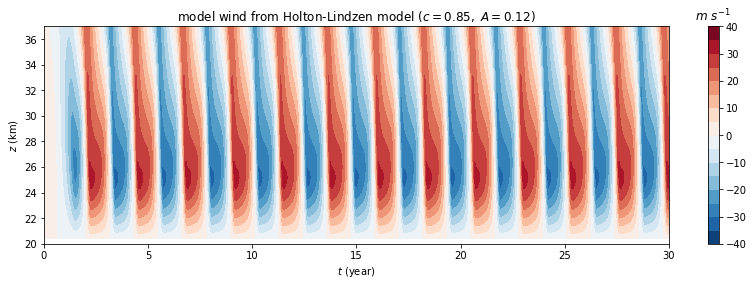

In [7]:
fig = plt.figure(figsize = (14, 4))
ax = plt.axes()
cs = ax.contourf(t, z, u, levels = np.arange(-40, 41, 5), cmap = "RdBu_r")
ax.set_xlim(0, 30)
ax.set_ylim(20, 37)

ax.set_xlabel(r"$t$ (year)")
ax.set_ylabel(r"$z$ (km)")
ax.set_title(r"model wind from Holton-Lindzen model ($c = %.2f,\ A = %.2f$)" % (c, amp))
cax = plt.colorbar(cs)
cax.ax.set_title(r"$m\ s^{-1}$")

fig.savefig("../figures/holton_lindzen_holvmoller.png", bbox_inches = 'tight', dpi = 150)

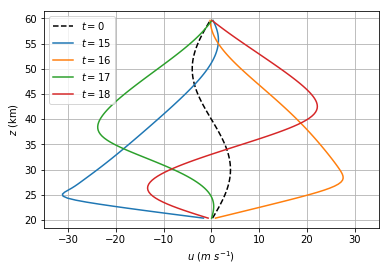

In [7]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(u[:, 0], z, 'k--', label = r"$t = 0$")
ax.plot(u[:, 2499], z, label = r"$t = 15$")
ax.plot(u[:, 2666], z, label = r"$t = 16$")
ax.plot(u[:, 2833], z, label = r"$t = 17$")
ax.plot(u[:, 2999], z, label = r"$t = 18$")

ax.set_xlabel(r"$u\ (m\ s^{-1})$")
ax.set_ylabel(r"$z$ (km)")
ax.set_xlim((-35, 35))
ax.grid()
ax.legend()

fig.savefig("../figures/holton_lindzen_snapshot.png", bbox_inches = 'tight', dpi = 150)

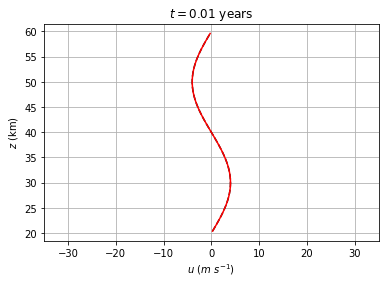

In [8]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(u[:, 0], z, 'k--')
line, = ax.plot(u[:, 0], z, 'r-')

ax.grid()
ax.set_xlim(-35, 35)
ax.set_xlabel(r"$u\ (m\ s^{-1})$")
ax.set_ylabel(r"$z$ (km)")

def animate(i):
    line.set_xdata(u[:, 5 * i])
    ax.set_title(r"$t = %.2f$ years" % t[5 * i])
    return line,

anim = animation.FuncAnimation(fig, animate, interval = 10, save_count = 1000)
HTML(anim.to_html5_video())

In [35]:
# QBO model of Holton & Lindzen (e.g. Oliver Buhler's book)
# an integral equation, implementation based on Jacques Vanneste's MATLAB implementation

# add a stochastic variation to c
np.random.seed()

L = 10   # height of domain (non-dim)
N = 100  # number of grid points in z
nu = 0.1 # viscosity

amp  = 0.12  # amplitude of wave
c    = 0.85  # tuning parameters (wave speed)
tmax = 30    # years

# set up the time and space grid
z = np.arange(1, N + 1) * L / (N + 1)
dz = L / (N + 1)
k = np.arange(1, N + 1) # vertical wave numbers

dt = 0.1 # time step
nt = int(tmax * 500 / 30 / dt)
t = np.arange(1, nt + 1) * dt * tmax / 500;

decay = np.exp(-nu * dt * k ** 2) # decay factor for viscous dissipation step

u = np.zeros((N, nt))
u[:, 0] = 0.1 * np.sin(2 * np.pi * z / L) # initial condition

for j in range(nt - 1):
    uhat = fft.dst(u[:, j], type = 2)
    uhat *= decay # viscous dissipation in spectral space
    v = fft.idst(uhat, type = 2) / (2 * N) # normalisation
    int1 = 0.1 * np.cumsum((v - c) ** -2) * dz
    int2 = 0.1 * np.cumsum((v + c) ** -2) * dz
    u[:, j + 1] = v + dt * ( (amp + np.random.normal(0.0, 0.01)) * np.exp(-int1) * (v - c) ** -2
                            -(amp + np.random.normal(0.0, 0.2)) * np.exp(-int2) * (v + c) ** -2)
z = 20 + 4 * z
u *= 40

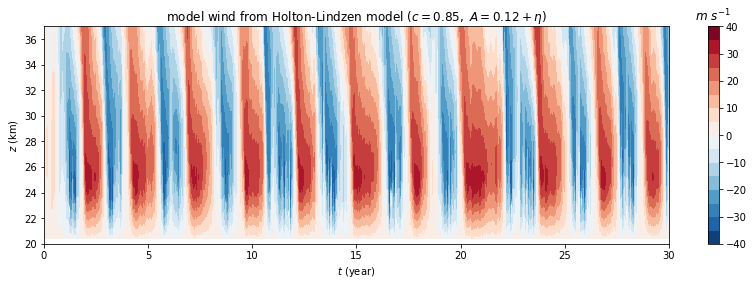

In [39]:
fig = plt.figure(figsize = (14, 4))
ax = plt.axes()
cs = ax.contourf(t, z, u, levels = np.arange(-40, 41, 5), cmap = "RdBu_r")
ax.set_xlim(0, 30)
ax.set_ylim(20, 37)

ax.set_xlabel(r"$t$ (year)")
ax.set_ylabel(r"$z$ (km)")
ax.set_title(r"model wind from Holton-Lindzen model ($c = %.2f,\ A = %.2f + \eta$)" % (c, amp))
cax = plt.colorbar(cs)
cax.ax.set_title(r"$m\ s^{-1}$")

fig.savefig("../figures/holton_lindzen_holvmoller_stochastic.png", bbox_inches = 'tight', dpi = 150)

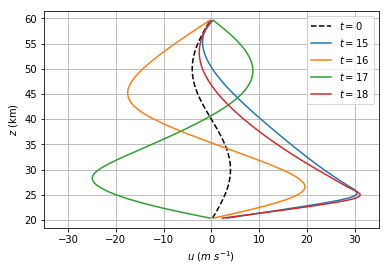

In [40]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(u[:, 0], z, 'k--', label = r"$t = 0$")
ax.plot(u[:, 2499], z, label = r"$t = 15$")
ax.plot(u[:, 2666], z, label = r"$t = 16$")
ax.plot(u[:, 2833], z, label = r"$t = 17$")
ax.plot(u[:, 2999], z, label = r"$t = 18$")

ax.set_xlabel(r"$u\ (m\ s^{-1})$")
ax.set_ylabel(r"$z$ (km)")
ax.set_xlim((-35, 35))
ax.grid()
ax.legend()

fig.savefig("../figures/holton_lindzen_snapshot_stochastic.png", bbox_inches = 'tight', dpi = 150)

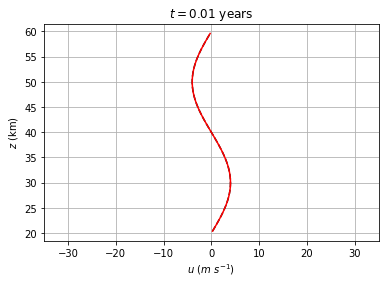

In [38]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(u[:, 0], z, 'k--')
line, = ax.plot(u[:, 0], z, 'r-')

ax.grid()
ax.set_xlim(-35, 35)
ax.set_xlabel(r"$u\ (m\ s^{-1})$")
ax.set_ylabel(r"$z$ (km)")

def animate(i):
    line.set_xdata(u[:, 5 * i])
    ax.set_title(r"$t = %.2f$ years" % t[5 * i])
    return line,

anim = animation.FuncAnimation(fig, animate, interval = 10, save_count = 1000)
HTML(anim.to_html5_video())